# PBMC clustering and signatures matrix construction example tutorial
In this tutorial, you will learn to use Scanpy to cluster one PBMC dataset and use marker genes of immune cells to extract pure cell type clusters. Then we will make signature matrix for deconvolution using the gene expression profile from pure cell type clusters. This tutorial is just for demonstration purpose, you can explore other PBMC datasets, as well as new approaches to build signature matrix.

In [2]:
#@Install scanpy 
!pip install scanpy
!pip install python-igraph
!pip install louvain
!pip install multipy

     |████████████████████████████████| 10.3MB 17.8MB/s 
     |████████████████████████████████| 122kB 51.1MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 1.2MB 38.5MB/s 
  Created wheel for sinfo: filename=sinfo-0.3.1-cp37-none-any.whl size=7012 sha256=4d3d18dbfd716e148a54745dd186f3dfd2f1035b592f5bd941eefebd924f6a6a
  Stored in directory: /root/.cache/pip/wheels/11/f0/23/347d6d8e59787c2bc272162d18223dc3b45bd6dc40aceee6af
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=c38088ea85e10ede461ca17a0ae99e70e10a08c11656a4e963421a37e96eba69
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=dc1deb648617686be14c6aa15e84fa6e720e52f308f56bbc38d2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import scanpy as sc
import math
from multipy.fdr import lsu
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/My Drive/BME_230B_Spring_2021/Final_project/PBMC_clustering/PBMC_datasets')

Mounted at /content/drive


### Introduction - Scanpy usage

Here we preprocess one of the PBMC dataset (PBMC_6kv1_tpm.csv), followed by louvain clutering. we use Scanpy object 'var' to represent genes, 'obs' for samples. For detailed Scanpy data structure: https://falexwolf.de/img/scanpy/anndata.svg




In [40]:
# Load PBMC_6kv1_tpm.csv dataset with 5419 cells and 32738 genes. Datasets were preprocessed into log2-tpm space
# tutorial: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
adata = sc.read("PBMC_6kv1_tpm.csv").T
print(adata.X.shape)
adata

(5419, 32738)


AnnData object with n_obs × n_vars = 5419 × 32738

In [41]:
#pre-processing steps from Scanpy
#store full gene expression to compute cluster centroid later
full_expression = pd.DataFrame(adata.X, index=adata.obs.index, columns=adata.var.index)

#filter cells that have less than 200 genes expressed
#filter genes that expressed in at least 1% of all cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=int(0.01*len(adata.obs)))

#check result after filtering
adata


AnnData object with n_obs × n_vars = 5418 × 8242
    obs: 'n_genes'
    var: 'n_cells'

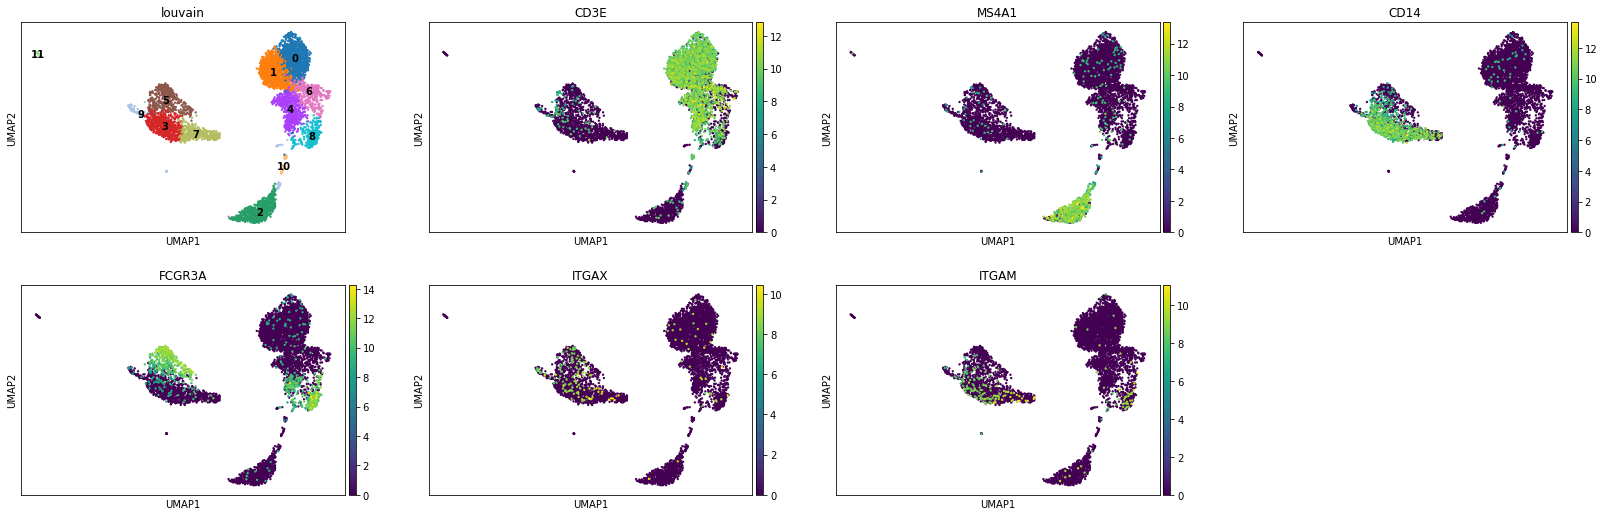

In [42]:
random_seed = 1
sc.pp.pca(adata, n_comps = 40)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, random_state = random_seed)
sc.tl.louvain(adata, random_state = random_seed, resolution=1.0) 
sc.tl.umap(adata, min_dist = 0.5,random_state = random_seed)
#T Cell marker CD3E+, B Cell marker CD19+, Monocyte marker CD14+, Natural Killer Cell marker FCGR3A+, Dendritic Cell marker ITGAX+, ITGAM+
sc.pl.umap(adata, color=['louvain','CD3E','MS4A1','CD14','FCGR3A','ITGAX','ITGAM'],legend_loc='on data') 

# MS4A1 and CD19

In [43]:
#identify cell type clusters by marker genes and assign cell types in adata object
adata.obs['cells'] = adata.obs['louvain']
assign_cell = {'0':'T cell','1':'T cell','4':'T cell','6':'T cell',
               '2': 'B cell',
               '3': 'Monocyte','7':'Monocyte',
               '5': 'NK cell',
               '8':'Dendritic cell',
               '9':'unknown', '10':'unknown', '11':'unknown'}
adata.obs.replace({'cells': assign_cell},inplace=True)


In [47]:
#Now, compute the average expression for each cell type using all genes
full_expression_filtered = full_expression.loc[adata.obs.index,:]
clusters = [x for x in set(adata.obs["cells"]) if x != 'unknown']
for cluster in clusters:   
    avg_colname = "avg_" + cluster
    adata.var[avg_colname] = adata.X[adata.obs['cells']==cluster].mean(axis=0)


### Build signature matrix
Now we compute differential expressed genes using t-test between highest and second highest clusters for each gene, you can try different method for this step


In [104]:
# compute the highest and second highest clusters for each gene
highest_clusters_list = []
second_highest_clusters_list = []
p_vec = []
avg_cols = ["avg_" + cluster for cluster in clusters]
for gene in adata.var.index:
    rank_index = sorted(range(len(adata.var[avg_cols].columns)), key=lambda k: adata.var[avg_cols].loc[gene][k], reverse=True)
    highest_cluster = adata.var[avg_cols].columns[rank_index[0]]
    second_highest_cluster = adata.var[avg_cols].columns[rank_index[1]]
    highest_clusters_list.append(highest_cluster)
    second_highest_clusters_list.append(second_highest_cluster)
    highest_cluster_expression = full_expression_filtered.loc[adata.obs['cells'] == highest_cluster.split('_')[1]][gene]
    second_highest_cluster_expression = full_expression_filtered.loc[adata.obs['cells'] == second_highest_cluster.split('_')[1]][gene]
    t_result = scipy.stats.ttest_ind(highest_cluster_expression, second_highest_cluster_expression, equal_var=False)
    if math.isnan(t_result.pvalue):
        p_vec.append(1)
    else:
        p_vec.append(t_result.pvalue)



In [119]:
# replace 0's with very low p-values to avoid log errors.
minimum_pval = min(i for i in p_vec if i > 0)
p_vec = [x if x != 0 else minimum_pval for x in p_vec]

# Running Benjamini Hochberg multiple testing correction, with a False Discovery Rate of 0.01
p_valid = lsu(np.array(p_vec), q=0.01)


In [126]:
# build final signature matrix that contains the average expression for each signature gene for each cluster
sig_genes = adata.var.index[p_valid]
sig_matrix = adata.var.loc[sig_genes,avg_cols]
print(sig_matrix.shape)

(643, 5)


In [128]:
# save signature matrix to a tsv file
sig_matrix.to_csv('PBMC_example_signature_matrix_v1.tsv',sep='\t')

In [127]:
sig_matrix.head()

,avg_B cell,avg_T cell,avg_Monocyte,avg_NK cell,avg_Dendritic cell
HES4,0.030047,0.052596,0.230973,4.056226,0.064468
ISG15,2.021464,2.753572,6.163073,8.265964,4.518619
MIB2,0.181869,0.559658,0.141529,0.343801,2.001178
TNFRSF14,1.622469,1.680862,1.328645,3.233350,1.764890
ENO1,3.375020,4.602201,5.454778,6.942675,5.858187


### plot signature matrix

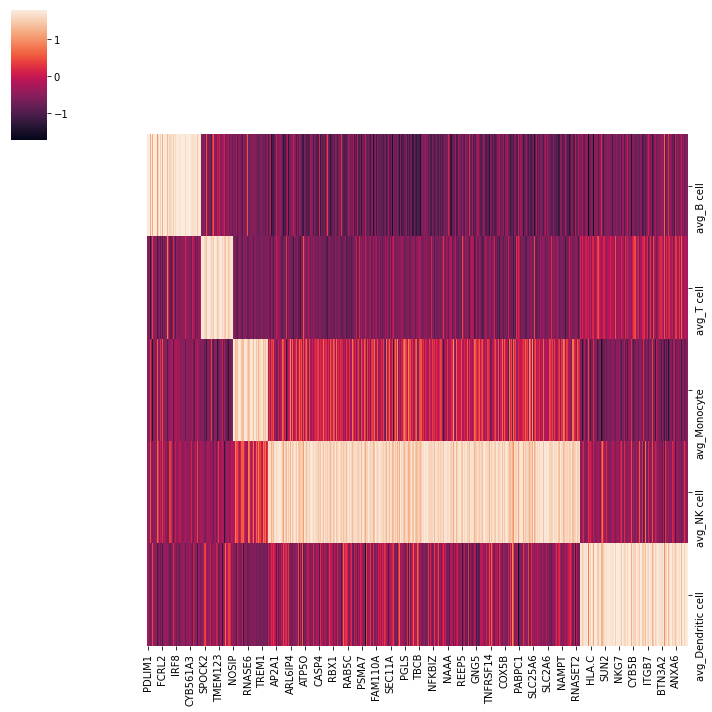

In [121]:
#plot signature matrix but sorted, here the light band in each cluster are highest expressed genes, so we can have a nicer looking plot
max_cluster_vec = list()
for g in list(sig_matrix.index):
    i = np.argmax(sig_matrix.loc[g])
    max_cluster_vec.append(i)
sig_matrix["max_cluster"] = max_cluster_vec
sig_matrix_sorted = sig_matrix.sort_values(by="max_cluster")
ax = sns.clustermap(sig_matrix_sorted.iloc[:,[0,1,2,3,4]].T, row_cluster = False, col_cluster=False, z_score = 1) 